# FAKE NEWS DETECTION USING RNN

# Loading the Datasets

You need to load both CSV files and label them appropriately (e.g., 1 for fake news and 0 for real news).

In [2]:
import pandas as pd

# Load the two datasets
fake_df = pd.read_csv('/Users/sora/Downloads/Fake.csv')
true_df = pd.read_csv('/Users/sora/Downloads/True.csv')

# Preview the datasets
print(fake_df.head())
print(true_df.head())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept t

Both datasets contain a text column with the articles, we can create labels for them.

# Labeling the Datasets

Add a label column to each dataset to differentiate fake and real news. For example, 1 for fake news and 0 for real news.

In [3]:
# Add a label column: 1 for fake news, 0 for real news
fake_df['label'] = 1
true_df['label'] = 0

# Combining the Datasets

Once labeled, we can combine both datasets into a single DataFrame.

In [4]:
# Combine the datasets
df = pd.concat([fake_df, true_df], ignore_index=True)

# Shuffle the dataset to mix fake and real news
df = df.sample(frac=1).reset_index(drop=True)

# Check the structure of the combined dataset
print(df.head())
print(df['label'].value_counts())  # Check the distribution of fake and real news

                                               title  \
0  Meeting between Trump and Japan's Abe has ende...   
1  TRUMP DELIVERS MESSAGE TO PUTIN: “Russia, If Y...   
2  MURDERERS AND RAPISTS FOR HILLARY: VA Governor...   
3  Hurricane Irma will 'devastate' part of U.S.: ...   
4  Fox News Cuts Off Terror Expert Before He Coul...   

                                                text       subject  \
0  NEW YORK (Reuters) - A meeting in New York on ...  politicsNews   
1  Trump says he s never talked to Putin and the ...      politics   
2  The good news for Hillary is that she should b...      politics   
3  WASHINGTON (Reuters) - Anticipating that Hurri...     worldnews   
4  If you were watching Fox News this morning, yo...     left-news   

                 date  label  
0  November 17, 2016       0  
1        Jul 27, 2016      1  
2        Apr 23, 2016      1  
3  September 8, 2017       0  
4        Sep 15, 2017      1  
label
1    23481
0    21417
Name: count, dtype: int64


# Cleaning the Dataset

Now that the data is combined, you can proceed with cleaning by removing missing values and any irrelevant columns (if present).

In [5]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values in the 'text' column
df = df.dropna(subset=['text'])

# If any unnecessary columns are present, you can drop them (e.g., 'title', 'date')
if 'title' in df.columns:
    df = df.drop(['title', 'date'], axis=1)

# Final structure check
print(df.head())

title      0
text       0
subject    0
date       0
label      0
dtype: int64
                                                text       subject  label
0  NEW YORK (Reuters) - A meeting in New York on ...  politicsNews      0
1  Trump says he s never talked to Putin and the ...      politics      1
2  The good news for Hillary is that she should b...      politics      1
3  WASHINGTON (Reuters) - Anticipating that Hurri...     worldnews      0
4  If you were watching Fox News this morning, yo...     left-news      1


# Preprocessing the Text Data

Next, you’ll preprocess the text data, including tokenization, normalization, and padding.

## a. Preprocessing Text

Normalize the text by removing punctuation, stopwords, and converting everything to lowercase.

In [6]:
import string
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Preprocess the text: lowercase, remove punctuation and stopwords
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = ''.join([char for char in text if char not in string.punctuation])  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Apply preprocessing to the 'text' column
df['text'] = df['text'].apply(preprocess_text)

# Check an example after preprocessing
print(df['text'].head())

[nltk_data] Downloading package stopwords to /Users/sora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    new york reuters meeting new york thursday us ...
1    trump says never talked putin allegation worki...
2    good news hillary able connect hardened crimin...
3    washington reuters anticipating hurricane irma...
4    watching fox news morning probably saw terror ...
Name: text, dtype: object


## b. Tokenization and Padding

Tokenize the preprocessed text and pad the sequences to ensure all articles are of the same length for model training. 

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define maximum vocabulary size and sequence length
vocab_size = 10000
maxlen = 500

# Initialize the tokenizer and fit it on the combined text data
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['text'].values)

# Convert the news articles to sequences of integers
sequences = tokenizer.texts_to_sequences(df['text'].values)

# Pad the sequences to ensure uniform length
padded_sequences = pad_sequences(sequences, maxlen=maxlen)

print(f"Padded sequences shape: {padded_sequences.shape}")

Padded sequences shape: (44898, 500)


# Preparing the Labels

You can extract the labels into a numpy array for model training. 

In [8]:
import numpy as np

# Convert labels to numpy array
labels = df['label'].values
print(f"Labels shape: {labels.shape}")

Labels shape: (44898,)


# Splitting the Dataset for Training and Testing

Next, split the data into training and test sets to evaluate the model later. 

In [9]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Check the shape of the training and test sets
print(f"Training data shape: {x_train.shape}, Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}, Test labels shape: {y_test.shape}")

Training data shape: (35918, 500), Training labels shape: (35918,)
Test data shape: (8980, 500), Test labels shape: (8980,)


# Saving the Preprocessed Dataset

Finally, save the cleaned and preprocessed dataset for later use in model training.

In [10]:
import pickle

# Save the preprocessed dataset as a binary file
with open('fake_news_preprocessed_dataset.pkl', 'wb') as f:
    pickle.dump((x_train, y_train, x_test, y_test), f)

print("Preprocessed Fake News Detection dataset saved.")

Preprocessed Fake News Detection dataset saved.


# Steps to Build and Train the Model

## 1. Setting Up the Environment

First, ensure that you have TensorFlow installed in your environment. If not, install it using:

In [11]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


## 2. Model Architecture

We will use an LSTM-based model since it works well with sequential data and can remember patterns in the text better than a basic RNN. The architecture will consist of:

- Embedding Layer: Converts words into dense vectors.
- LSTM Layer: Learns from sequential dependencies in the text.
- Dense Layers: Used to classify the output as fake or real.

In [12]:
# Load the preprocessed dataset from the binary file
with open('fake_news_preprocessed_dataset.pkl', 'rb') as f:
    x_train, y_train, x_test, y_test = pickle.load(f)

print("Preprocessed Fake News Detection dataset loaded.")

Preprocessed Fake News Detection dataset loaded.


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define model parameters
vocab_size = 10000  # Vocabulary size
embedding_dim = 128  # Embedding dimension
maxlen = 500  # Maximum length of input sequences

# Building the Sequential model
model = Sequential()

# Embedding layer: Convert words into dense vectors
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))

# LSTM layer: Learns sequential dependencies in text
model.add(LSTM(units=128))

# Dropout layer: Helps prevent overfitting
model.add(Dropout(0.5))

# Dense layer: Output layer with sigmoid activation for binary classification (fake = 1, real = 0)
model.add(Dense(1, activation='sigmoid'))

# Compile the model: binary crossentropy for binary classification
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Create a dummy input to force the model to build (generate random integers in the range of [0, vocab_size-1])
dummy_input = tf.random.uniform((1, maxlen), minval=0, maxval=vocab_size, dtype=tf.int32)  # Add maxval here

# Pass the dummy input to the model to initialize it
model(dummy_input)

# Now, print the model summary
model.summary()

/Users/sora/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (1, 500, 128)          │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (1, 128)               │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 1)                 │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,411,713 (5.39 MB)

 Trainable params: 1,411,713 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Set hyperparameters
epochs = 5  # Number of times the model will see the entire dataset
batch_size = 64  # Number of samples to process before updating the model

# Train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size)

# Save the trained model
model.save("fake_news_detection_model.h5")

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 240s 426ms/step - accuracy: 0.9041 - loss: 0.2336 - val_accuracy: 0.9873 - val_loss: 0.0511
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 232s 413ms/step - accuracy: 0.9844 - loss: 0.0570 - val_accuracy: 0.9923 - val_loss: 0.0341
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 245s 436ms/step - accuracy: 0.9826 - loss: 0.0599 - val_accuracy: 0.9949 - val_loss: 0.0216
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 244s 433ms/step - accuracy: 0.9958 - loss: 0.0162 - val_accuracy: 0.9961 - val_loss: 0.0161
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 233s 415ms/step - accuracy: 0.9982 - loss: 0.0077 - val_accuracy: 0.9950 - val_loss: 0.0249


In [15]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

281/281 ━━━━━━━━━━━━━━━━━━━━ 26s 94ms/step - accuracy: 0.9954 - loss: 0.0236
Test Accuracy: 0.9950


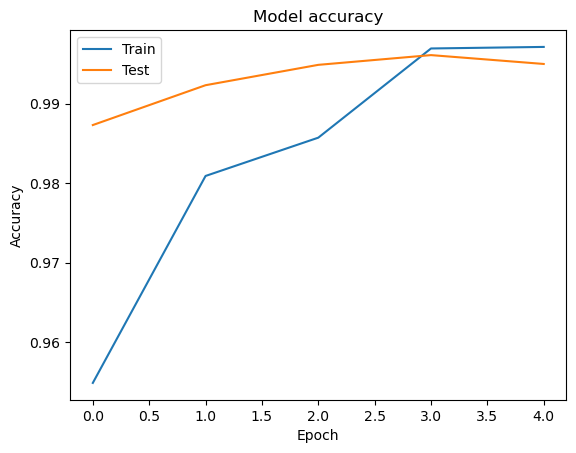

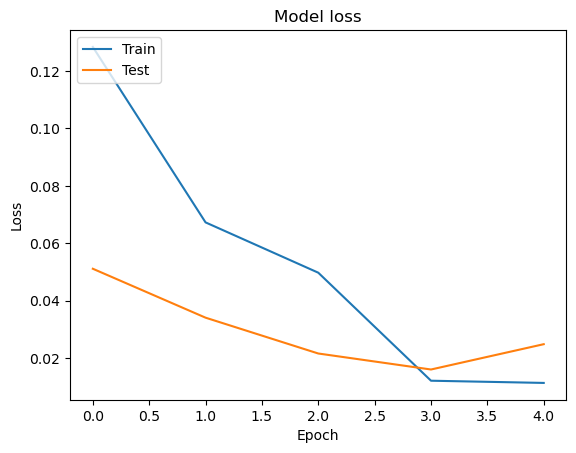

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# Define model parameters
vocab_size = 10000  # Vocabulary size
embedding_dim = 128  # Embedding dimension
maxlen = 500  # Maximum length of input sequences

# Hyperparameter grid (reduced search space)
lstm_units_list = [128, 256]  # Two values for LSTM units
dropout_rates = [0.3, 0.5]  # Two values for dropout rates
batch_sizes = [32, 64]  # Two values for batch sizes
learning_rates = [0.001]  # Single value for learning rate
epochs = [3]  # Reduce epochs to 3 during tuning

best_accuracy = 0
best_hyperparams = {}

# Early stopping to avoid long training on poor-performing models
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

# Experiment with combinations of hyperparameters (fewer combinations now)
for lstm_units in lstm_units_list:
    for dropout_rate in dropout_rates:
        for batch_size in batch_sizes:
            for lr in learning_rates:
                for epoch in epochs:
                    print(f"Training with LSTM units={lstm_units}, Dropout={dropout_rate}, "
                          f"Batch Size={batch_size}, Learning Rate={lr}, Epochs={epoch}")
                    
                    # Build the model
                    model = Sequential()
                    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
                    model.add(LSTM(units=lstm_units))
                    model.add(Dropout(dropout_rate))
                    model.add(Dense(1, activation='sigmoid'))
                    
                    # Compile the model with the current learning rate
                    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
                    
                    # Train the model
                    history = model.fit(x_train, y_train, epochs=epoch, batch_size=batch_size, 
                                        validation_data=(x_test, y_test), callbacks=[early_stopping], verbose=1)
                    
                    # Get validation accuracy
                    val_accuracy = max(history.history['val_accuracy'])
                    
                    # Update the best hyperparameters if performance improves
                    if val_accuracy > best_accuracy:
                        best_accuracy = val_accuracy
                        best_hyperparams = {
                            'LSTM units': lstm_units,
                            'Dropout': dropout_rate,
                            'Batch Size': batch_size,
                            'Learning Rate': lr,
                            'Epochs': epoch
                        }
                        
                        print(f"New Best Model Found: Validation Accuracy = {val_accuracy:.4f}")
                        print(f"Best Hyperparameters: {best_hyperparams}")

# After tuning, print out the best hyperparameters
print(f"Best Validation Accuracy: {best_accuracy}")
print(f"Best Hyperparameters: {best_hyperparams}")

Training with LSTM units=128, Dropout=0.3, Batch Size=32, Learning Rate=0.001, Epochs=3
Epoch 1/3


/Users/sora/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1123/1123 ━━━━━━━━━━━━━━━━━━━━ 422s 375ms/step - accuracy: 0.9119 - loss: 0.2321 - val_accuracy: 0.9783 - val_loss: 0.0766
Epoch 2/3
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 360s 321ms/step - accuracy: 0.9875 - loss: 0.0425 - val_accuracy: 0.9911 - val_loss: 0.0317
Epoch 3/3
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 380s 339ms/step - accuracy: 0.9970 - loss: 0.0126 - val_accuracy: 0.9965 - val_loss: 0.0114
New Best Model Found: Validation Accuracy = 0.9965
Best Hyperparameters: {'LSTM units': 128, 'Dropout': 0.3, 'Batch Size': 32, 'Learning Rate': 0.001, 'Epochs': 3}
Training with LSTM units=128, Dropout=0.3, Batch Size=64, Learning Rate=0.001, Epochs=3
Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 233s 413ms/step - accuracy: 0.9158 - loss: 0.1888 - val_accuracy: 0.9844 - val_loss: 0.0509
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 1408s 3s/step - accuracy: 0.9910 - loss: 0.0313 - val_accuracy: 0.9934 - val_loss: 0.0262
Training with LSTM units=128, Dropout=0.5, Batch Size=32, Learning Rate=0.001, Epochs=3
Epoch 1/3
1

In [ ]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss for training and validation data
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Show the plot
    plt.tight_layout()
    plt.show()